<a href="https://colab.research.google.com/github/rubygitflow/GANs/blob/master/University_of_Artificial_Intelligence_NLP_HomeWork_7_Pro_Text2Images_(CUB_200_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP.Lesson 7.1.Text2Images

http://www.vision.caltech.edu/visipedia/CUB-200.html

In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

## Checking the GPU

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import os
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()
if len(GPUs)>0:
  gpu = GPUs[0]
else:
  print('GPU turned off')
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM FREE: "+humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  if len(GPUs)>0:
    print("Gen RAM FREE: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    print("GPU Model: " + gpu.name)

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=0533a3551dfe59502aec78a458d76b80aec4fb0e4b8c81491149ae284d5c4088
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM FREE: 12.7 GB  | Proc size: 342.9 MB
Gen RAM FREE: 15079MB | Used: 0MB | Util   0% | Total 15079MB
GPU Model: Tesla T4


#Готовим данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/Базы/NLP/birds.zip -d /content/birds.zip

In [ ]:
!unzip birds.zip

In [ ]:
!mkdir results

In [ ]:
# !wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

--2020-09-20 01:10:37--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/file/d/1hbzc_P1FuxMkcabkgn9ZKinBwW683j45/view [following]
--2020-09-20 01:10:37--  https://drive.google.com/file/d/1hbzc_P1FuxMkcabkgn9ZKinBwW683j45/view
Resolving drive.google.com (drive.google.com)... 74.125.142.138, 74.125.142.102, 74.125.142.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz        [ <=>                ]  60.84K  --.-KB/s    in 0.02s   

2020-09-20 01:10:37 (2.47 MB/s) - ‘CUB_200_2011.tgz’ saved [62301]



In [ ]:
!cp /content/drive/My\ Drive/Базы/NLP/CUB_200_2011.tgz -d /content/CUB_200_2011.tgz

In [ ]:
!tar zxvf /content/CUB_200_2011.tgz

#Код

In [ ]:
def load_class_ids(class_info_file_path): #загружаем

    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids
      
def load_embeddings(embeddings_file_path): #загружаем эмбеддинги
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings
 
def load_filenames(filenames_file_path): #загружаем список всех файлов
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames
 
def load_bounding_boxes(dataset_dir): #загружаем BB и возвращаем словарь файл:BB

    # путь к файлу
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # читаем файлы
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # создаем список имен файлов
    file_names = df_file_names[1].tolist()

    # подготавливаем словарь
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # записываем координаты BB
    for i in range(0, len(file_names)):
        # получаем
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict

def get_img(img_path, bbox, image_size): #загрузка, обрезка по BB, ресайз
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img
 
def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size): #загружаем весь датасет
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]

        try:
            # Загружаем изображения
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    return X, y, embeddings

In [ ]:
def generate_c(x): #reparametrisation trick
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c
  
  
def build_embedding_compressor_model(): #сжатие эмбеддингов
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def build_stage1_generator(): #генератор на стадии 1
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

def build_stage1_discriminator(): #дискриминатор, принимающий изображение и эмбеддинг описания изображения
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis
  
def build_adversarial_model(gen_model, dis_model): #общая модель
    input_layer = Input(shape=(1024,))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

In [ ]:
def KL_loss(y_true, y_pred): #Расстояние Кульбака-Лейблера
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss
    

def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

In [ ]:
def save_rgb_img(img, path): #сохраняем картинку по пути
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

In [ ]:
#гиперпараметры
data_dir = "/content/birds/"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
image_size = 64
batch_size = 64
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs = 1000
condition_dim = 128

#указываем путь к необходимым файлам
embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

filenames_file_path_train = train_dir + "/filenames.pickle"
filenames_file_path_test = test_dir + "/filenames.pickle"

class_info_file_path_train = train_dir + "/class_info.pickle"
class_info_file_path_test = test_dir + "/class_info.pickle"

cub_dataset_dir = "/content/CUB_200_2011"

#создаем оптимизаторы
dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

#загружаем датасеты
X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                  class_info_file_path=class_info_file_path_train,
                                                  cub_dataset_dir=cub_dataset_dir,
                                                  embeddings_file_path=embeddings_file_path_train,
                                                  image_size=(64, 64))

X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                class_info_file_path=class_info_file_path_test,
                                                cub_dataset_dir=cub_dataset_dir,
                                                embeddings_file_path=embeddings_file_path_test,
                                                image_size=(64, 64))
#создаем и компилируем сети


stage1_dis = build_stage1_discriminator()
stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

stage1_gen = build_stage1_generator()
stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                          optimizer=gen_optimizer, metrics=None)


# создаем лейблы для тренировки
# label smoothing
real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=float) + 0.1

embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)
embeddings:  (2933, 10, 1024)
Embeddings shape: (2933, 10, 1024)


In [ ]:
for epoch in range(epochs):
    print("========================================")
    print("Epoch is:", epoch)
    print("Number of batches", int(X_train.shape[0] / batch_size))

    gen_losses = []
    dis_losses = []


    number_of_batches = int(X_train.shape[0] / batch_size)
    for index in range(number_of_batches):
        print("Batch:{}".format(index+1))
        
        #генерим фейковы изображения для дискриминатора
        z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
        image_batch = (image_batch - 127.5) / 127.5

        # Генерим фейковые изображения
        fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

        # Сжатые эмбеддинги
        compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
        compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
        compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

        #тренируем дискриминатор
        dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                  np.reshape(real_labels, (batch_size, 1)))
        dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                  np.reshape(fake_labels, (batch_size, 1)))
        dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                    np.reshape(fake_labels[1:], (batch_size-1, 1)))

        d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

        print("d_loss_real:{}".format(dis_loss_real))
        print("d_loss_fake:{}".format(dis_loss_fake))
        print("d_loss_wrong:{}".format(dis_loss_wrong))
        print("d_loss:{}".format(d_loss))

        #тренируем генератор
        g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
        print("g_loss:{}".format(g_loss))

        dis_losses.append(d_loss)
        gen_losses.append(g_loss)

    
    # На каждой четной эпохе создаем очередную партию изображений для визуализации
    if epoch % 2 == 0:
        z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
        embedding_batch = embeddings_test[0:batch_size]
        fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

        # Save images
        for i, img in enumerate(fake_images[:10]):
            save_rgb_img(img, "results/gen_{}_{}.png".format(epoch, i))

#сохраняем модели
stage1_gen.save_weights("stage1_gen.h5")
stage1_dis.save_weights("stage1_dis.h5")

In [ ]:
!ls results

In [ ]:
!cp -r /content/results  /content/drive/My\ Drive/Базы/NLP/Birds/results

In [ ]:
#сохраняем модели
stage1_gen.save_weights("/content/drive/My Drive/Базы/NLP/Birds/results/stage1_gen.h5")
stage1_dis.save_weights("/content/drive/My Drive/Базы/NLP/Birds/results/stage1_dis.h5")

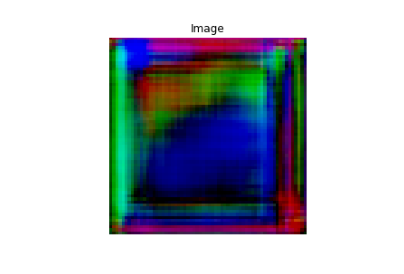

In [ ]:
image = np.array(Image.open('results/gen_0_0.png'), dtype=np.uint8)
plt.figure(figsize=(7,7))
plt.axis("off")
plt.imshow(image)
plt.show()

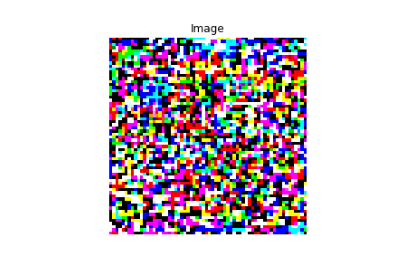

In [ ]:
image = np.array(Image.open('results/gen_704_9.png'), dtype=np.uint8)
plt.figure(figsize=(7,7))
plt.axis("off")
plt.imshow(image)
plt.show()